In [38]:
import numpy as np
import pandas as pd

data = pd.read_csv(r'C:\Users\Gareth.Ahern\Desktop\NonCommercialOver1000\Attempt2\13.csv')
data.head()

,Flight_ID,Position_DateTime,Latitude,Longitude
0,619465375,13/07/2020 09:07,52.35548,0.27679
1,619465375,13/07/2020 09:07,52.36037,0.28023
2,619465375,13/07/2020 09:07,52.36633,0.28447
3,619465375,13/07/2020 09:07,52.37145,0.28808
4,619465375,13/07/2020 09:08,52.38872,0.30212


In [8]:
import geopandas as gpd
shapefile = r'C:\Users\Gareth.Ahern\Desktop\gadm36_GBR_shp\gadm36_GBR_3.shp'
street_map = gpd.read_file(shapefile)
street_map.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.1_1,Barnsley,None,GBR.1.1.1_1,Barnsley,None,None,Metropolitan borough,Metropolitan borough,None,GB.BX.BX,"POLYGON ((-1.78997 53.47293, -1.79306 53.47778..."
1,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.2_1,Bath and North East Somerset,None,GBR.1.2.1_1,Bath and North East Somerset,None,None,Unitary authority,Unitary authority,None,GB.BN.BN,"POLYGON ((-2.68629 51.31516, -2.68066 51.32836..."
2,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.3_1,Bedfordshire,None,GBR.1.3.1_1,Bedford,None,None,Unitary authority,Unitary authority,None,GB.FO.FO,"POLYGON ((-0.58508 52.11364, -0.58806 52.11805..."
3,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.4_1,Birmingham,None,GBR.1.4.1_1,Birmingham,None,None,Metropolitan borough (city),Metropolitan borough (city),None,GB.BI.BI,"POLYGON ((-1.73417 52.51014, -1.73984 52.50894..."
4,GBR,United Kingdom,GBR.1_1,England,None,GBR.1.5_1,Blackburn with Darwen,None,GBR.1.5.1_1,Blackburn with Darwen,None,None,Unitary authority,Unitary authority,None,GB.BW.BW,"POLYGON ((-2.51111 53.63377, -2.51317 53.63582..."


{'init': 'epsg:4326'}
Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'NL_NAME_2', 'GID_3', 'NAME_3', 'VARNAME_3', 'NL_NAME_3', 'TYPE_3',
       'ENGTYPE_3', 'CC_3', 'HASC_3', 'geometry'],
      dtype='object')


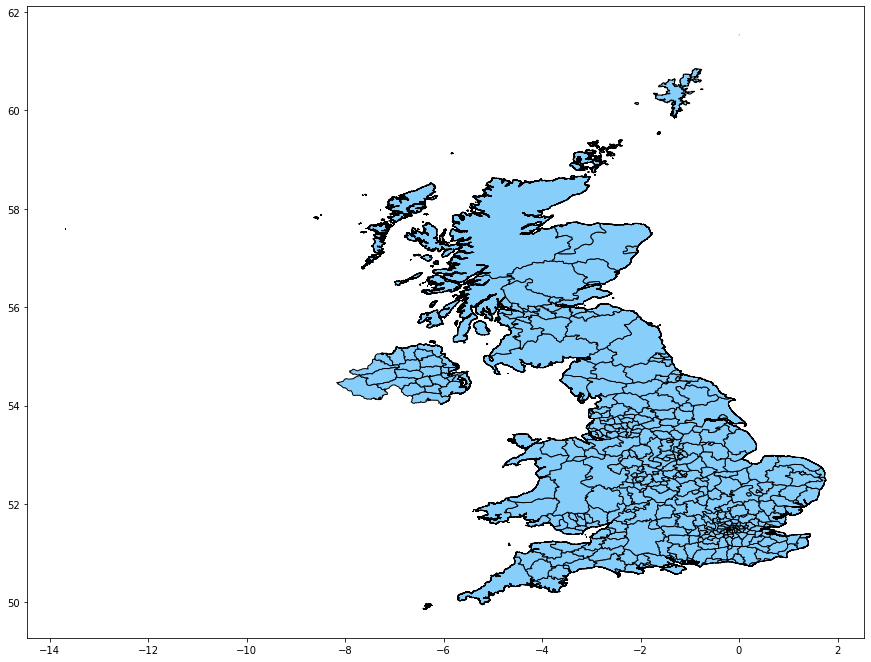

In [87]:
#Lets test out shp map
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, color = 'lightskyblue', edgecolor = 'black')
print(street_map.crs)
print(street_map.columns)

In [57]:
#Turn our 
#data['geometry'] = gpd.points_from_xy(data.Longitude, data.Latitude)
#gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(data.Longitude, data.Latitude)]
gdf = gpd.GeoDataFrame(data.drop(['Longitude', 'Latitude'], axis=1), crs={'init': 'epsg:4326'}, geometry=geometry)
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [85]:
data_with_counties = gpd.sjoin(gdf, street_map, how="inner", op='intersects')
data_with_counties['District'] = data_with_counties['NAME_3']
print(type(data_with_counties))

data_with_counties = data_with_counties[['Flight_ID', 'District']]
data_with_counties = data_with_counties.groupby(['District']).count()
data_with_counties.reset_index(inplace=True)
data_with_counties.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,District,Flight_ID
0,Aberdeen,797
1,Aberdeenshire,1745
2,Adur,30
3,Allerdale,61
4,Amber Valley,71


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

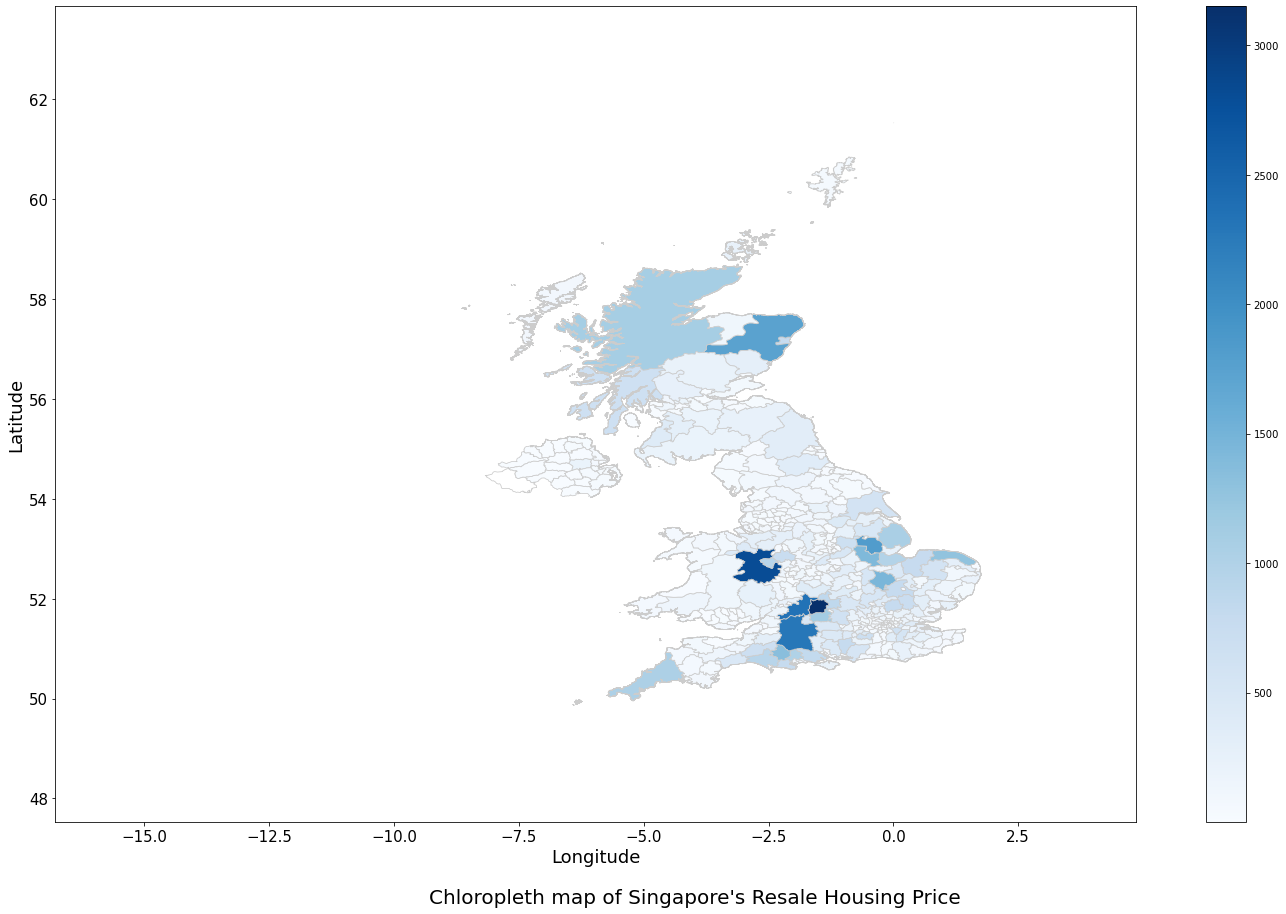

In [89]:
merged_df = street_map.set_index('NAME_3').join(data_with_counties.set_index('District'))
merged_df.reset_index(inplace=True)

fig, ax = plt.subplots(1, figsize=(25, 15))
merged_df['coords'] = merged_df['geometry'].apply(lambda x: x.representative_point().coords[:])
merged_df['coords'] = [coords[0] for coords in merged_df['coords']]

#We can label the areas, but there are too many areas => too many labels, so I wont do this
#for idx, row in merged_df.iterrows():
#    plt.annotate(text=row['NAME_3'], xy=row['coords'], horizontalalignment='center')
    
ax.margins(0.2, 0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
txt='Chloropleth map of Airspace'
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=20)

merged_df.plot(column='Flight_ID', ax=ax, legend=True, cmap='Blues', linewidth=0.8, edgecolor='0.8')